## Regression part a


### 1:

Explain what variable is predicted based on which other variables and what
you hope to accomplish by the regression. Mention your feature transformation
choices such as one-of-K coding. Since we will use regularization momentarily,
apply a feature transformation to your data matrix X such that each column
has mean 0 and standard deviation 1.


In [8]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt

In [9]:
%store -r data

1. Split your data into features (independent variables) and the target variable (Gross)


In [10]:
X = data.drop("Gross", axis=1)  # Features (indipendent variables)
X = X.drop(columns="title")
y = data["Gross"]  # Target variable (dipendent variable)
# X["bias"] = 1

In [11]:
# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler to your feature matrix and transform it
X_scaled = scaler.fit_transform(X)

2. Define a range of values for the regularization parameter λ (alpha) that you want to test.

These values were decided by trying different combinations of them and how the plots were


In [12]:
lambdas = np.arange(1, 500, 10, dtype="float")

3. Perform 10-fold cross-validation with Ridge regression for each value of λ


In [13]:
errors = []

best_error = 1
best_lambda = None

for lambda_i in lambdas:
    model = Ridge(alpha=lambda_i)
    # 10 fold cross validation
    scores = cross_val_score(model, X_scaled, y, cv=10)
    mean_score = scores.mean()
    # generalization error for lambda_i
    gen_err = 1 - mean_score
    errors.append(gen_err)

    if gen_err < best_error:
        best_error = gen_err  # update the lowest generalization error

        best_lambda = lambda_i  # update the best lambda


print(f"best error = {best_error}, best lambda = {best_lambda}")

best error = 0.6487628394212387, best lambda = 161.0


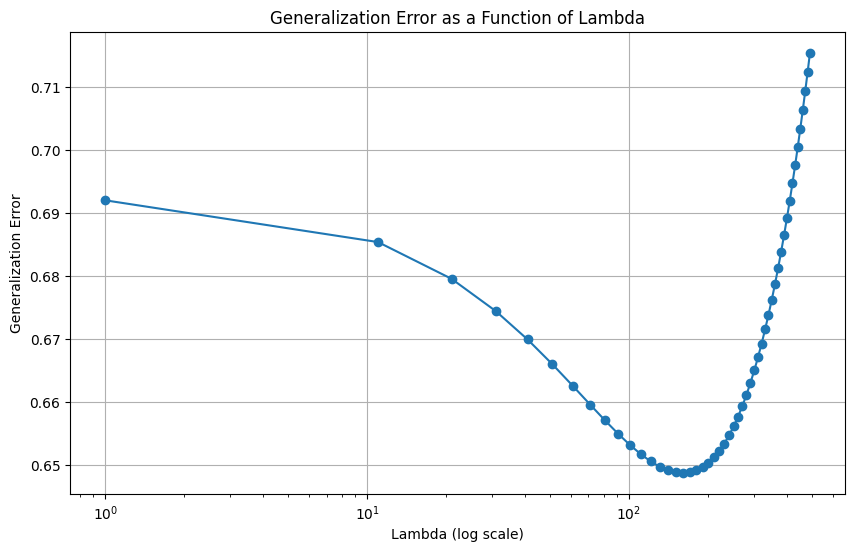

In [14]:
# Create a plot of generalization error as a function of λ
plt.figure(figsize=(10, 6))
plt.semilogx(lambdas, errors, marker="o", linestyle="-")
plt.title("Generalization Error as a Function of Lambda")
plt.xlabel("Lambda (log scale)")
plt.ylabel("Generalization Error")
plt.grid(True)
plt.show()

4. Find the λ that gives the lowest generalization error


Values of coefficients are the weigths for each feature and intercept is the bias term
$$y=(biasterm) + weigths*(features)$$


In [15]:
# Create and train a Ridge regression model
model = Ridge(alpha=best_lambda)  # Use the best_alpha value you've determined
model.fit(X_scaled, y)  # X is your feature matrix, y is your target variable

# Access the coefficients
coefficients = model.coef_  # Coefficients (weights)
intercept = model.intercept_  # Intercept (bias term)

In [16]:
coefficients

array([-2.68033647e+07, -1.42442736e+07,  1.30938971e+08,  5.31093829e+07,
        3.46004724e+07,  1.16913960e+07,  7.33797296e+07])

In [17]:
intercept

435227473.55111825

This is the plot as 14.2 in the book


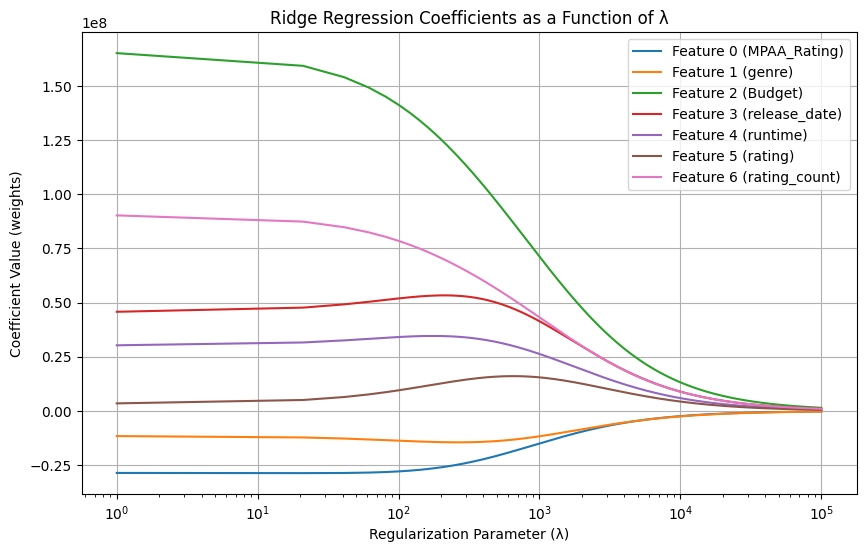

In [18]:
coefficients = []
lambdas1 = np.arange(1, 100000, 20, dtype=float)

for alpha in lambdas1:
    # Create and fit a Ridge regression model
    model = Ridge(alpha=alpha)
    model.fit(X_scaled, y)  # Use your transformed data

    # Get the coefficients for this λ
    coef = model.coef_
    coefficients.append(coef)

# Convert coefficients to a NumPy array
coefficients = np.array(coefficients)

# Create a plot to visualize the coefficients
plt.figure(figsize=(10, 6))
for i in range(coefficients.shape[1]):
    plt.semilogx(lambdas1, coefficients[:, i], label=f"Feature {i} ({X.columns[i]})")
plt.title("Ridge Regression Coefficients as a Function of λ")
plt.xlabel("Regularization Parameter (λ)")
plt.ylabel("Coefficient Value (weights)")
plt.legend()
plt.grid()
plt.show()

## Regression part b


In this section, we will compare three models: the regularized
linear regression model from the previous section, an artificial neural network (ANN) and a baseline.

We are interested in two questions:

- Is one model better than the other?
- Is either model better than a trivial baseline?.

We will attempt to answer
these questions with two-level cross-validation.


### 1 Implement two-level cross-validation

(see algorithm 6 of the lecture notes). We will use 2-level cross-validation to compare the models with K1 = K2 = 10 folds.

As a baseline model, we will apply a linear regression model with no features, i.e. it computes the mean of y on the training data, and use this value to predict y on the test data.

Make sure you can fit an ANN model to the data.

As complexity-controlling parameter for the ANN, we will use the number of hidden units5 h.
Based on a few test-runs, select a reasonable range of values for h (which should include h = 1), and describe the range of values you will use for h and λ.


The baseline model is a simple linear regression model that computes the mean of the target variable (y) on the training data and uses this mean value to predict y on the test data.


In [19]:
import torch
import toolbox_functions
from sklearn import model_selection

In [20]:
# Parameters for Neural Network
n_hidden_units = 1
n_replicates = 1  # number of networks trained in each k-fold
max_iter = 10000
N, M = X.shape


def model():
    return torch.nn.Sequential(
        torch.nn.Linear(M, n_hidden_units),  # M features to n_hidden_units
        torch.nn.Tanh(),  # 1st transfer function,
        torch.nn.Linear(n_hidden_units, 1),  # n_hidden_units to 1 output neuron
        # no final tranfer function, i.e. "linear output"
    )


loss_fn = torch.nn.MSELoss()

In [26]:
# Define the number of folds for outer and inner cross-validation
outer_folds = 10
inner_folds = 10

# Initialize objects for outer cross-validation
outer_cv = model_selection.KFold(n_splits=outer_folds, shuffle=True, random_state=42)

# List to store the scores of outer cross-validation
outer_scores = []

for k, (train_index, test_index) in enumerate(outer_cv.split(X_scaled)):
    print("\nCrossvalidation fold: {0}/{1}".format(k + 1, outer_folds))

    X_par = X_scaled[train_index]
    y_par = y.to_numpy()[train_index]

    X_test = X_scaled[test_index]
    y_test = y.to_numpy()[test_index]

    ## BASELINE NO LAMBDA NO FEATURES
    # Calculate the mean of y in the training data
    y_mean = np.mean(y_par)

    # Create an array of predicted values using the mean
    y_pred_baseline = np.full(y_test.shape, y_mean)

    # Calculate the mean squared error (MSE) for the baseline model
    mse_baseline = ((y_pred_baseline - y_test) ** 2).mean()

    # Print or store the MSE for the baseline model
    print(f"Baseline MSE: {mse_baseline}")

    ## RIDGE REGRESSION
    lambdas = np.arange(1, 200, 1, dtype="float")

    # errors contains generalization error for each lambda
    errors_ridge = []
    best_error_lambda_i = 1
    best_lambda_i_ridge = None

    # RIDGE REGRESSION AS BEFORE
    for lambda_i in lambdas:
        ridge_model = Ridge(alpha=lambda_i)

        # 10 fold cross validation
        scores = cross_val_score(ridge_model, X_par, y_par, cv=inner_folds)
        mean_score = scores.mean()

        # generalization error for lambda_i
        gen_err_lambda_i_ridge = 1 - mean_score

        errors_ridge.append(gen_err_lambda_i_ridge)

        if gen_err_lambda_i_ridge < best_error_lambda_i:
            best_error_lambda_i = (
                gen_err_lambda_i_ridge  # update the lowest generalization error
            )
            best_lambda_i_ridge = lambda_i  # update the best lambda

    # print(errors_ridge)
    print(f"best error = {best_error_lambda_i}, best lambda = {best_lambda_i_ridge}")

    # ## ANN
    # # Some parameters for Neural Network are defined before the loop
    # errors_NN = []
    # # Convert training and test set for current CV fold, convert to tensors
    # X_par_NN = torch.Tensor(X_par)
    # y_par_NN = torch.Tensor(y_par)
    # X_test_NN = torch.Tensor(X_test)
    # y_test_NN = torch.Tensor(y_test)

    # net, final_loss, learning_curve = toolbox_functions.train_neural_net(
    #     model,
    #     loss_fn,
    #     X=X_par_NN,
    #     y=y_par_NN,
    #     n_replicates=n_replicates,
    #     max_iter=max_iter,
    # )

    # # Determine estimated class labels for test set
    # y_test_est = net(X_test_NN)

    # # Determine errors and errors
    # se = (y_test_est.float() - y_test.float()) ** 2  # squared error
    # mse_NN = (sum(se).type(torch.float) / len(y_test)).data.numpy()  # mean
    # errors_NN.append(mse_NN)  # store error rate for current CV fold
    # print("\n\tBest loss: {}\n".format(final_loss))


Crossvalidation fold: 1/10
Baseline MSE: 1.4380800393496336e+17
[0.7028443422968065, 0.702148309308875, 0.7014623046193385, 0.7007861831058202, 0.7001198029849971, 0.6994630257085404, 0.6988157158629977, 0.6981777410734517, 0.6975489719107818, 0.6969292818023771, 0.6963185469461477, 0.6957166462276952, 0.6951234611405037, 0.6945388757090265, 0.6939627764145447, 0.6933950521236805, 0.6928355940194559, 0.6922842955347902, 0.6917410522883365, 0.6912057620225618, 0.6906783245439766, 0.6901586416654313, 0.6896466171503928, 0.6891421566591232, 0.688645167696685, 0.6881555595627017, 0.6876732433028011, 0.68719813166168, 0.6867301390377251, 0.6862691814391291, 0.685815176441446, 0.6853680431465298, 0.6849277021428055, 0.684494075466818, 0.6840670865660157, 0.6836466602627209, 0.6832327227192397, 0.6828252014040744, 0.6824240250591945, 0.6820291236683275, 0.6816404284262341, 0.6812578717089306, 0.6808813870448256, 0.6805109090867361, 0.680146373584754, 0.6797877173599317, 0.6794348782787573, 0

In [ ]:
from sklearn.model_selection import train_test_split

test_proportion = 0.3

# Split your data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=test_proportion
)

In [ ]:
from sklearn.linear_model import LinearRegression

# Create the baseline model
baseline_model = LinearRegression()

# Fit the model to the mean of the training target variable
baseline_model.fit(X_train, y_train)

# Make predictions using the trained baseline model
baseline_predictions = baseline_model.predict(X_test)

For the ANN model, you need to set up a range of values for the number of hidden units (h) and the regularization parameter (λ).


In [ ]:
# Define a range of values for hidden units (h)
hidden_units_range = [1, 10, 20, 30, 40, 50]

# Define a range of values for the regularization parameter (λ)
lambda_range = np.arange(1, 200, 1, dtype=float)